X_encoder shape: torch.Size([32, 29])
X_pm shape: torch.Size([32, 20])
X_pm_steam shape: torch.Size([32, 20])
y shape: torch.Size([32, 2])


/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Training Loss: 0.1536
Epoch 1/20, Validation Loss: 0.1602
Epoch 2/20, Training Loss: 0.0999
Epoch 2/20, Validation Loss: 0.1284
Epoch 3/20, Training Loss: 0.0826
Epoch 3/20, Validation Loss: 0.1405
Epoch 4/20, Training Loss: 0.0735
Epoch 4/20, Validation Loss: 0.1783
Epoch 5/20, Training Loss: 0.0646
Epoch 5/20, Validation Loss: 0.2939
Epoch 6/20, Training Loss: 0.0585
Epoch 6/20, Validation Loss: 0.3368
Epoch 7/20, Training Loss: 0.0557
Epoch 7/20, Validation Loss: 0.4196
Epoch 8/20, Training Loss: 0.0525
Epoch 8/20, Validation Loss: 0.3711
Epoch 9/20, Training Loss: 0.0517
Epoch 9/20, Validation Loss: 0.4343
Epoch 10/20, Training Loss: 0.0498
Epoch 10/20, Validation Loss: 0.4106
Epoch 11/20, Training Loss: 0.0491
Epoch 11/20, Validation Loss: 0.3897
Epoch 12/20, Training Loss: 0.0485
Epoch 12/20, Validation Loss: 0.4569
Early stopping triggered


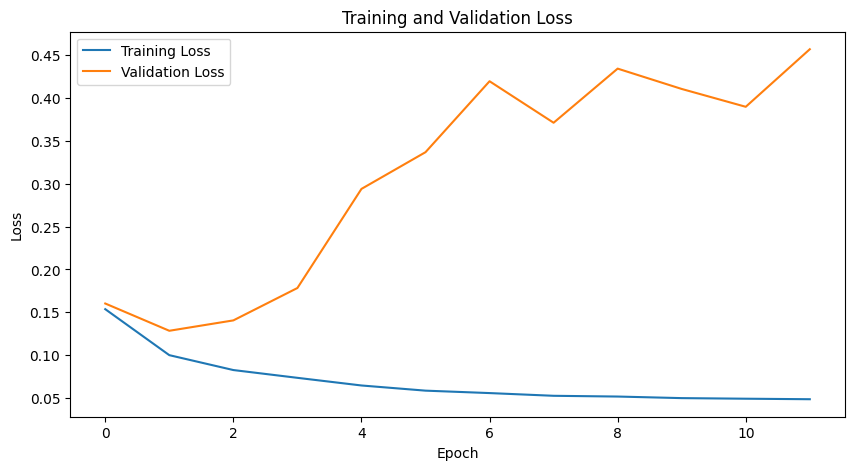

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, r2_score

random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc dữ liệu từ các tệp CSV đã chia sẵn
train_data = pd.read_csv('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/train.csv')
val_data = pd.read_csv('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/valid.csv')
test_data = pd.read_csv('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/test.csv')

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_5','PM_steam5','PM_10','PM_steam10','PM_15','PM_steam15'
                    ]
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month',
               'hour', 'minute','PM_s1','PM_5','PM_10','PM_15']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month',
                     'hour', 'minute','PM_lw1','PM_steam5','PM_steam10','PM_steam15']
y_columns = ['PM', 'PM_steam']

scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()  # Thêm scaler cho y

def preprocess_data(data):
    X_encoder = scaler_encoder.fit_transform(data[encoder_features])
    X_pm = scaler_pm.fit_transform(data[pm_features])
    X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
    y = scaler_y.fit_transform(data[y_columns])  # Chuẩn hóa y
    return torch.tensor(X_encoder, dtype=torch.float32), torch.tensor(X_pm, dtype=torch.float32), torch.tensor(X_pm_steam, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Tiền xử lý dữ liệu
X_train_enc, X_train_pm, X_train_pm_steam, y_train = preprocess_data(train_data)
X_val_enc, X_val_pm, X_val_pm_steam, y_val = preprocess_data(val_data)
X_test_enc, X_test_pm, X_test_pm_steam, y_test = preprocess_data(test_data)

# Tạo TensorDataset
train_dataset = TensorDataset(X_train_enc, X_train_pm, X_train_pm_steam, y_train)
val_dataset = TensorDataset(X_val_enc, X_val_pm, X_val_pm_steam, y_val)
test_dataset = TensorDataset(X_test_enc, X_test_pm, X_test_pm_steam, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Kiểm tra kích thước của các tensor
for X_enc, X_pm, X_pm_steam, y in train_loader:
    print(f"X_encoder shape: {X_enc.shape}")
    print(f"X_pm shape: {X_pm.shape}")
    print(f"X_pm_steam shape: {X_pm_steam.shape}")
    print(f"y shape: {y.shape}")
    break  # Chỉ cần in kích thước của batch đầu tiên

# Định nghĩa mô hình với Dropout và Batch Normalization
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar per time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=3, decoder_layers=3, d_model=16, dropout=0.3):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(29, d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(20, d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(20, d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình
model = MultiDeT()

# Định nghĩa hàm loss và optimizer với Weight Decay
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Thêm weight_decay

# Hàm huấn luyện mô hình với Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                # Combine the losses
                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            best_model_wts = model.state_dict()  # save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # load the best model weights
            break

    return train_losses, val_losses

# Huấn luyện mô hình với Early Stopping
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=10)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [2]:
import torch
import joblib

# Đường dẫn để lưu mô hình và scaler
model_save_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/best_model.pth'
scaler_encoder_save_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_encoder.pkl'
scaler_pm_save_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm.pkl'
scaler_pm_steam_save_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm_steam.pkl'
scaler_y_save_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_y.pkl'

# Lưu mô hình với các trọng số tốt nhất
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
# Lưu các scaler đã sử dụng
joblib.dump(scaler_encoder, scaler_encoder_save_path)
print(f"Scaler for encoder features saved to {scaler_encoder_save_path}")
joblib.dump(scaler_pm, scaler_pm_save_path)
print(f"Scaler for PM features saved to {scaler_pm_save_path}")
joblib.dump(scaler_pm_steam, scaler_pm_steam_save_path)
print(f"Scaler for PM_steam features saved to {scaler_pm_steam_save_path}")
joblib.dump(scaler_y, scaler_y_save_path)
print(f"Scaler for target values saved to {scaler_y_save_path}")


Model saved to /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/best_model.pth
Scaler for encoder features saved to /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_encoder.pkl
Scaler for PM features saved to /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm.pkl
Scaler for PM_steam features saved to /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm_steam.pkl
Scaler for target values saved to /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_y.pkl


In [3]:
import torch
import joblib
import numpy as np
import pandas as pd

# Đường dẫn để tải mô hình và scaler
model_load_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/best_model.pth'
scaler_encoder_load_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_encoder.pkl'
scaler_pm_load_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm.pkl'
scaler_pm_steam_load_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm_steam.pkl'
scaler_y_load_path = '/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_y.pkl'

# Khởi tạo lại mô hình với cùng cấu trúc
model = MultiDeT()  # Điều chỉnh cấu trúc nếu cần thiết
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Đặt mô hình vào chế độ đánh giá
print(f"Model loaded successfully from {model_load_path}")

# Tải lại các scaler đã lưu
scaler_encoder = joblib.load(scaler_encoder_load_path)
print(f"Scaler for encoder features loaded from {scaler_encoder_load_path}")

scaler_pm = joblib.load(scaler_pm_load_path)
print(f"Scaler for PM features loaded from {scaler_pm_load_path}")

scaler_pm_steam = joblib.load(scaler_pm_steam_load_path)
print(f"Scaler for PM_steam features loaded from {scaler_pm_steam_load_path}")

scaler_y = joblib.load(scaler_y_load_path)
print(f"Scaler for target values loaded from {scaler_y_load_path}")


Model loaded successfully from /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/best_model.pth
Scaler for encoder features loaded from /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_encoder.pkl
Scaler for PM features loaded from /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm.pkl
Scaler for PM_steam features loaded from /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm_steam.pkl
Scaler for target values loaded from /Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_y.pkl


/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_3257/655621634.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
# Khởi tạo và tải mô hình đã huấn luyện
model = MultiDeT()  # Giả sử MultiDeT() là class mô hình đã định nghĩa
model.load_state_dict(torch.load('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/best_model.pth'))
model.eval()  # Đặt mô hình vào chế độ đánh giá

# Tải các scaler đã lưu
scaler_encoder = joblib.load('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_encoder.pkl')
scaler_pm = joblib.load('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm.pkl')
scaler_pm_steam = joblib.load('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_pm_steam.pkl')
scaler_y = joblib.load('/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/1609 - save data/scaler_y.pkl')

# Đọc dữ liệu từ file CSV
data_file = "/Users/nguyendinhhuy/Desktop/NCKU/Rolling/Rolling 12092024/1609-1900/test.csv"
df = pd.read_csv(data_file)

df = pd.read_csv(data_file)
df['time_label'] = pd.to_datetime({
    'year': 2024,
    'month': df['month'],
    'day': df['day'],
    'hour': df['hour'],
    'minute': df['minute']
})

# all_features = set(encoder_features + pm_features + pm_steam_features)
# for feature in all_features - set(df.columns):
#     df[feature] = 0

/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_3257/2059181011.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/nguye

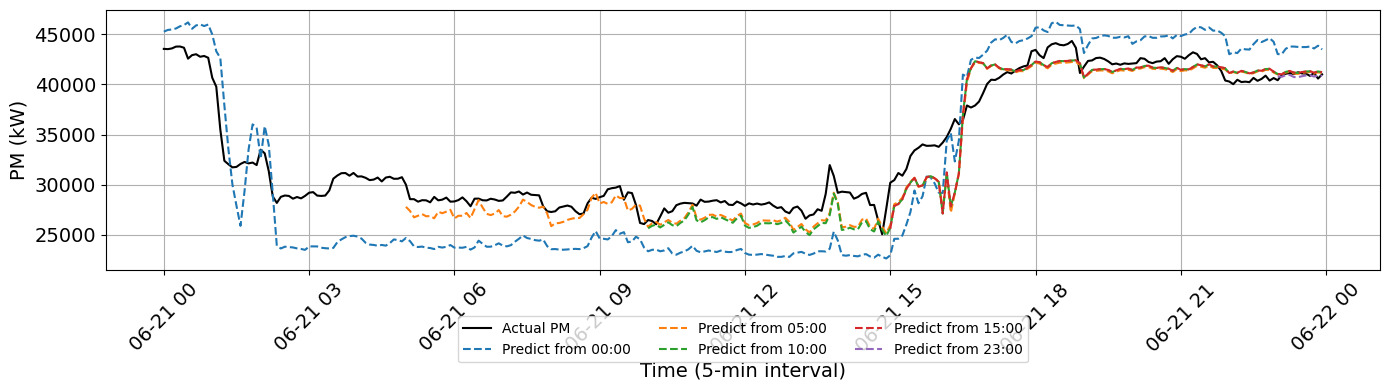

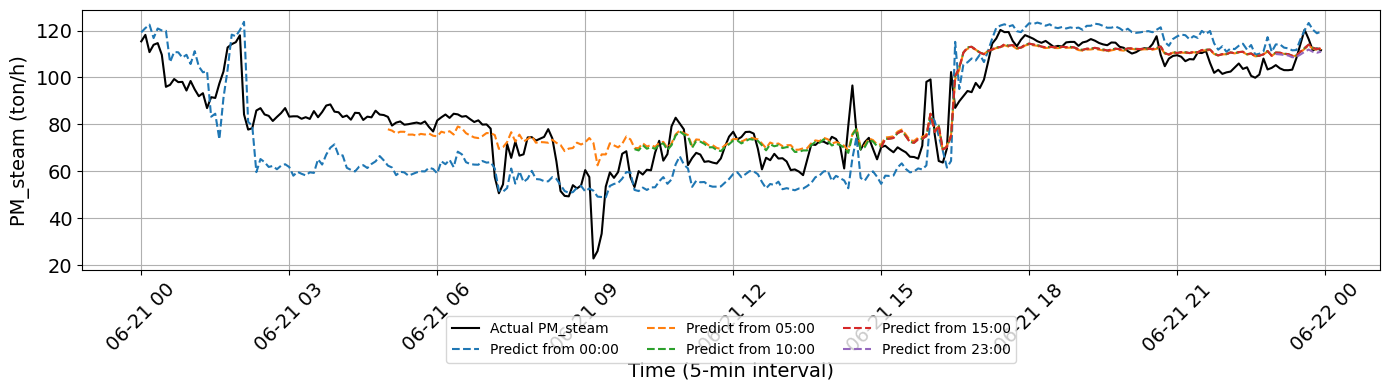

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day',
                    'month', 'hour', 'minute', 'PM_5', 'PM_steam5', 'PM_10',
                    'PM_steam10', 'PM_15', 'PM_steam15']

pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
               'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day',
               'month', 'hour', 'minute', 'PM_s1', 'PM_5', 'PM_10', 'PM_15']

pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                     'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day',
                     'month', 'hour', 'minute', 'PM_lw1', 'PM_steam5', 'PM_steam10',
                     'PM_steam15']

# Hàm thực hiện dự đoán cho một thời điểm
def make_prediction(input_data):
    X_enc = input_data[encoder_features].to_frame().T
    X_pm = input_data[pm_features].to_frame().T
    X_pm_steam = input_data[pm_steam_features].to_frame().T

    X_enc_scaled = torch.tensor(scaler_encoder.transform(X_enc), dtype=torch.float32)
    X_pm_scaled = torch.tensor(scaler_pm.transform(X_pm), dtype=torch.float32)
    X_pm_steam_scaled = torch.tensor(scaler_pm_steam.transform(X_pm_steam), dtype=torch.float32)

    with torch.no_grad():
        output_pm, output_pm_steam = model(X_enc_scaled, X_pm_scaled, X_pm_steam_scaled)
        combined_output = torch.cat([output_pm, output_pm_steam], dim=1)
        y_pred = scaler_y.inverse_transform(combined_output.numpy())
    return y_pred[0, 0], y_pred[0, 1]  # PM và PM_steam dự đoán

# Hàm cập nhật dữ liệu đầu vào với các giá trị dự đoán
def update_input_data_with_predictions(input_data, pred_pm, pred_pm_steam):
    # Cập nhật các giá trị dự đoán vào dữ liệu đầu vào
    input_data['PM_f'] = pred_pm
    input_data['qty'] = pred_pm_steam
    return input_data

# Khởi tạo khoảng thời gian dự báo
start_date = pd.Timestamp('2024-06-21 00:00:00')
end_date = pd.Timestamp('2024-06-21 23:55:00')
forecast_interval = pd.Timedelta(minutes=5)

# Chuẩn bị danh sách để lưu kết quả cho việc vẽ đồ thị
actuals_pm = df[(df['time_label'] >= start_date) & (df['time_label'] <= end_date)].sort_values('time_label')['PM'].tolist()
actuals_pm_steam = df[(df['time_label'] >= start_date) & (df['time_label'] <= end_date)].sort_values('time_label')['PM_steam'].tolist()
actual_times = df[(df['time_label'] >= start_date) & (df['time_label'] <= end_date)].sort_values('time_label')['time_label'].tolist()

all_predictions_pm = []
all_predictions_pm_steam = []
all_prediction_times = []

# Danh sách để lưu trữ các giá trị MAPE cho từng khoảng thời gian
all_mape_pm = []
all_mape_pm_steam = []

# Thực hiện dự báo rolling từ 0:00 đến 23:55
initial_start_date = start_date
while initial_start_date <= end_date:
    current_time = initial_start_date
    predictions_pm = []
    predictions_pm_steam = []
    prediction_times = []

    # Bắt đầu dự báo từ initial_start_date đến end_date
    while current_time <= end_date:
        input_data = df[df['time_label'] == current_time]
        if not input_data.empty:
            input_data = input_data.iloc[0]

            # Nếu không phải là dự báo đầu tiên, cập nhật đầu vào với dự báo trước đó
            if initial_start_date > start_date and prev_pred_pm is not None and prev_pred_pm_steam is not None:
                input_data = update_input_data_with_predictions(input_data, prev_pred_pm, prev_pred_pm_steam)

            # Thực hiện dự báo giá trị PM và PM_steam
            pred_pm, pred_pm_steam = make_prediction(input_data)
            predictions_pm.append(pred_pm)
            predictions_pm_steam.append(pred_pm_steam)
            prediction_times.append(current_time)

            # Cập nhật dự báo để làm đầu vào cho lần tiếp theo
            if current_time == initial_start_date:
                prev_pred_pm = pred_pm
                prev_pred_pm_steam = pred_pm_steam

        current_time += forecast_interval

    # Đảm bảo độ dài của dự đoán và giá trị thực tế khớp nhau
    min_length = min(len(predictions_pm), len(actuals_pm))
    predictions_pm = predictions_pm[:min_length]
    predictions_pm_steam = predictions_pm_steam[:min_length]
    actuals_pm_trimmed = actuals_pm[:min_length]
    actuals_pm_steam_trimmed = actuals_pm_steam[:min_length]
    prediction_times = prediction_times[:min_length]

    # Lưu các dự đoán vào danh sách
    all_predictions_pm.append(predictions_pm)
    all_prediction_times.append(prediction_times)
    all_predictions_pm_steam.append(predictions_pm_steam)

    # Tính toán MAPE tổng thể cho toàn bộ khoảng thời gian hiện tại
    valid_pm = np.array(actuals_pm_trimmed) != 0
    valid_pm_steam = np.array(actuals_pm_steam_trimmed) != 0

    if valid_pm.sum() > 0:
        mape_pm = np.mean(np.abs((np.array(actuals_pm_trimmed)[valid_pm] - np.array(predictions_pm)[valid_pm]) / np.array(actuals_pm_trimmed)[valid_pm])) * 100
        all_mape_pm.append(mape_pm)
    else:
        mape_pm = np.nan

    if valid_pm_steam.sum() > 0:
        mape_pm_steam = np.mean(np.abs((np.array(actuals_pm_steam_trimmed)[valid_pm_steam] - np.array(predictions_pm_steam)[valid_pm_steam]) / np.array(actuals_pm_steam_trimmed)[valid_pm_steam])) * 100
        all_mape_pm_steam.append(mape_pm_steam)
    else:
        mape_pm_steam = np.nan

    # Sửa lỗi khi cộng thời gian
    next_time = initial_start_date + forecast_interval

    # Chuyển sang thời điểm bắt đầu dự báo tiếp theo (cộng thêm 5 phút)
    initial_start_date = next_time

# Define the specific times (0h, 5h, 10h, 15h, 23h) for plotting
selected_hours = [0, 5, 10, 15, 23]
selected_times = [start_date + pd.Timedelta(hours=h) for h in selected_hours]

# Vẽ kết quả cho PM
plt.figure(figsize=(14, 4))

# Vẽ giá trị PM Actual
plt.plot(actual_times, actuals_pm, label='Actual PM', color='black', linestyle='-')

# Vẽ các dự đoán PM tại các thời điểm cụ thể
for i, (preds, times) in enumerate(zip(all_predictions_pm, all_prediction_times)):
    # Kiểm tra nếu Time (5-min interval) đầu tiên của dự báo nằm trong các thời điểm được chọn
    if times and times[0] in selected_times:
        plt.plot(times, preds, linestyle='--', label=f'Predict from {times[0].strftime("%H:%M")}')

plt.xlabel('Time (5-min interval)', fontsize=14)
plt.ylabel('PM (kW)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.grid(True)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

# Vẽ kết quả cho PM_steam
plt.figure(figsize=(14, 4))

# Vẽ giá trị PM_steam Actual
plt.plot(actual_times, actuals_pm_steam, label='Actual PM_steam', color='black', linestyle='-')

# Vẽ các dự đoán PM_steam tại các thời điểm cụ thể
for i, (preds, times) in enumerate(zip(all_predictions_pm_steam, all_prediction_times)):
    # Kiểm tra nếu Time (5-min interval) đầu tiên của dự báo nằm trong các thời điểm được chọn
    if times and times[0] in selected_times:
        plt.plot(times, preds, linestyle='--', label=f'Predict from {times[0].strftime("%H:%M")}')

plt.xlabel('Time (5-min interval)', fontsize=14)
plt.ylabel('PM_steam (ton/h)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.grid(True)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


đoạn mã này, không phải tính mape theo từng khoảng thời gian 0h-23h55, 0h05-23h55, 0h10-23h55,..
a copy đoạn mã dưới cùng và hỏi như ri là ra, tại nó tính mape bị sai nên kết quả e sai

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define features
encoder_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day',
                    'month', 'hour', 'minute', 'PM_5', 'PM_steam5', 'PM_10',
                    'PM_steam10', 'PM_15', 'PM_steam15']

pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
               'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day',
               'month', 'hour', 'minute', 'PM_s1', 'PM_5', 'PM_10', 'PM_15']

pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                     'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day',
                     'month', 'hour', 'minute', 'PM_lw1', 'PM_steam5', 'PM_steam10',
                     'PM_steam15']

# Prediction function
def make_prediction(input_data):
    X_enc = input_data[encoder_features].to_frame().T
    X_pm = input_data[pm_features].to_frame().T
    X_pm_steam = input_data[pm_steam_features].to_frame().T

    X_enc_scaled = torch.tensor(scaler_encoder.transform(X_enc), dtype=torch.float32)
    X_pm_scaled = torch.tensor(scaler_pm.transform(X_pm), dtype=torch.float32)
    X_pm_steam_scaled = torch.tensor(scaler_pm_steam.transform(X_pm_steam), dtype=torch.float32)

    with torch.no_grad():
        output_pm, output_pm_steam = model(X_enc_scaled, X_pm_scaled, X_pm_steam_scaled)
        combined_output = torch.cat([output_pm, output_pm_steam], dim=1)
        y_pred = scaler_y.inverse_transform(combined_output.numpy())
    return y_pred[0, 0], y_pred[0, 1]  # Predicted PM and PM_steam

# Update input data with predictions
def update_input_data_with_predictions(input_data, pred_pm, pred_pm_steam):
    input_data['PM_f'] = pred_pm
    input_data['qty'] = pred_pm_steam
    return input_data

# Forecast interval
start_date = pd.Timestamp('2024-06-21 00:00:00')
end_date = pd.Timestamp('2024-06-21 23:55:00')
forecast_interval = pd.Timedelta(minutes=5)

# Filter actuals within forecast period for MAPE calculation
actuals_filtered = df[(df['time_label'] >= start_date) & (df['time_label'] <= end_date)].sort_values('time_label')
actuals_pm = actuals_filtered['PM'].tolist()
actuals_pm_steam = actuals_filtered['PM_steam'].tolist()
actual_times = actuals_filtered['time_label'].tolist()

all_predictions_pm = []
all_predictions_pm_steam = []
all_prediction_times = []

# Lists to store MAPE values
all_mape_pm = []
all_mape_pm_steam = []

# Rolling forecast from 00:00 to 23:55
initial_start_date = start_date
while initial_start_date <= end_date:
    current_time = initial_start_date
    predictions_pm = []
    predictions_pm_steam = []
    prediction_times = []

    while current_time <= end_date:
        input_data = df[df['time_label'] == current_time]
        if not input_data.empty:
            input_data = input_data.iloc[0]

            if initial_start_date > start_date and 'prev_pred_pm' in locals() and 'prev_pred_pm_steam' in locals():
                input_data = update_input_data_with_predictions(input_data, prev_pred_pm, prev_pred_pm_steam)

            pred_pm, pred_pm_steam = make_prediction(input_data)
            predictions_pm.append(pred_pm)
            predictions_pm_steam.append(pred_pm_steam)
            prediction_times.append(current_time)

            if current_time == initial_start_date:
                prev_pred_pm = pred_pm
                prev_pred_pm_steam = pred_pm_steam

        current_time += forecast_interval

    # Only use predictions that match the actuals time range
    valid_indices = [i for i, time in enumerate(prediction_times) if time in actual_times]
    predictions_pm = [predictions_pm[i] for i in valid_indices]
    predictions_pm_steam = [predictions_pm_steam[i] for i in valid_indices]
    prediction_times = [prediction_times[i] for i in valid_indices]

    min_length = min(len(predictions_pm), len(actuals_pm))
    predictions_pm = predictions_pm[:min_length]
    predictions_pm_steam = predictions_pm_steam[:min_length]
    actuals_pm_trimmed = actuals_pm[:min_length]
    actuals_pm_steam_trimmed = actuals_pm_steam[:min_length]
    prediction_times = prediction_times[:min_length]

    all_predictions_pm.append(predictions_pm)
    all_prediction_times.append(prediction_times)
    all_predictions_pm_steam.append(predictions_pm_steam)

    # Calculate MAPE only for valid actuals (non-zero)
    valid_pm = np.array(actuals_pm_trimmed) != 0
    valid_pm_steam = np.array(actuals_pm_steam_trimmed) != 0

    if valid_pm.sum() > 0:
        mape_pm = np.mean(np.abs((np.array(actuals_pm_trimmed)[valid_pm] - np.array(predictions_pm)[valid_pm]) / np.array(actuals_pm_trimmed)[valid_pm])) * 100
        all_mape_pm.append(mape_pm)

    if valid_pm_steam.sum() > 0:
        mape_pm_steam = np.mean(np.abs((np.array(actuals_pm_steam_trimmed)[valid_pm_steam] - np.array(predictions_pm_steam)[valid_pm_steam]) / np.array(actuals_pm_steam_trimmed)[valid_pm_steam])) * 100
        all_mape_pm_steam.append(mape_pm_steam)

    # Move to the next interval
    initial_start_date += forecast_interval

# Calculate average MAPE, ignoring NaNs
average_mape_pm = np.nanmean(all_mape_pm)
average_mape_pm_steam = np.nanmean(all_mape_pm_steam)

# Print the MAPE values
for i, (mape_pm, mape_pm_steam) in enumerate(zip(all_mape_pm, all_mape_pm_steam)):
    print(f"MAPE for interval {i}: PM = {mape_pm:.2f}%, PM_steam = {mape_pm_steam:.2f}%")

print(f"Average MAPE: PM = {average_mape_pm:.2f}%, PM_steam = {average_mape_pm_steam:.2f}%")


MAPE for interval 0: PM = 12.56%, PM_steam = 15.17%
MAPE for interval 1: PM = 3.31%, PM_steam = 10.84%
MAPE for interval 2: PM = 3.36%, PM_steam = 11.25%
MAPE for interval 3: PM = 3.65%, PM_steam = 11.64%
MAPE for interval 4: PM = 3.94%, PM_steam = 11.96%
MAPE for interval 5: PM = 4.20%, PM_steam = 12.16%
MAPE for interval 6: PM = 4.49%, PM_steam = 12.32%
MAPE for interval 7: PM = 4.73%, PM_steam = 12.44%
MAPE for interval 8: PM = 4.84%, PM_steam = 12.63%
MAPE for interval 9: PM = 5.00%, PM_steam = 12.78%
MAPE for interval 10: PM = 5.19%, PM_steam = 12.95%
MAPE for interval 11: PM = 5.38%, PM_steam = 13.30%
MAPE for interval 12: PM = 5.56%, PM_steam = 13.63%
MAPE for interval 13: PM = 5.81%, PM_steam = 13.97%
MAPE for interval 14: PM = 6.01%, PM_steam = 14.30%
MAPE for interval 15: PM = 6.27%, PM_steam = 14.57%
MAPE for interval 16: PM = 6.68%, PM_steam = 14.89%
MAPE for interval 17: PM = 7.55%, PM_steam = 15.16%
MAPE for interval 18: PM = 7.84%, PM_steam = 15.39%
MAPE for interval 19:

# **TEST**